In [1]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Get data
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-09-29 15:35:40--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.80.48, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  41.8MB/s    in 10s     

2020-09-29 15:35:51 (41.0 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip --q -o Food-5K.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food-5K/training/1_1223.jpg  
  inflating: Food-5K/training/1_1237.jpg  
  inflating: Food-5K/training/0_1223.jpg  
  inflating: Food-5K/training/1_349.jpg  
  inflating: Food-5K/training/1_70.jpg  
  inflating: Food-5K/training/1_64.jpg  
  inflating: Food-5K/training/0_628.jpg  
  inflating: Food-5K/training/0_166.jpg  
  inflating: Food-5K/training/1_375.jpg  
  inflating: Food-5K/training/1_413.jpg  
  inflating: Food-5K/training/0_600.jpg  
  inflating: Food-5K/training/1_407.jpg  
  inflating: Food-5K/training/0_614.jpg  
  inflating: Food-5K/training/1_58.jpg  
  inflating: Food-5K/training/0_172.jpg  
  inflating: Food-5K/training/1_361.jpg  
  inflating: Food-5K/training/0_199.jpg  
  inflating: Food-5K/training/0_1009.jpg  
  inflating: Food-5K/training/0_827.jpg  
  inflating: Food-5K/training/0_9.jpg  
  inflating: Food-5K/training/0_833.jpg  
  inflating: Food-5K/training/1_1009.jpg  
  inflating: Food-5K/trai

In [4]:
# Data is currently formated by all files starting with 0 are non foods and all with 1 are foods

# Create the dirs to store the data asin keras' format
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [5]:
# Now move all the images into the correct folders
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [6]:
# Paths
train_path = "data/train"
valid_path = "data/test"

# Image size
IMAGE_SIZE = [200, 200]

In [7]:
image_files = glob(train_path + "/*/*.jpg")
valid_image_files = glob(valid_path + "/*/*.jpg")

folders = glob(train_path + "/*")
folders

['data/train/nonfood', 'data/train/food']

In [8]:
# Get the pre trained model with the trained weights and with only the convolutions
pmt = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights="imagenet",
    include_top=False
)

58892288/58889256 [==============================] - 0s 0us/step


In [9]:
# Freeze the weights of the pre trained model
pmt.trainable = False

In [10]:
# Create the feature map (what will be added to the pretrained model)

K = len(folders) # number of classes
x = Flatten()(pmt.output)
x = Dense(K, activation="softmax")(x)

In [11]:
# Create the model
model = Model(inputs=pmt.input, outputs=x)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [12]:
# Prepare the image generator
gen = ImageDataGenerator (
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [13]:
batch_size=128

# Creat the generators
train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# Compile and train the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size))
)

Epoch 1/10
24/24 [==============================] - 60s 2s/step - loss: 1.6961 - accuracy: 0.9177 - val_loss: 0.7190 - val_accuracy: 0.9690
Epoch 2/10
24/24 [==============================] - 55s 2s/step - loss: 0.4398 - accuracy: 0.9810 - val_loss: 0.7546 - val_accuracy: 0.9770
Epoch 3/10
24/24 [==============================] - 54s 2s/step - loss: 0.2657 - accuracy: 0.9830 - val_loss: 0.6287 - val_accuracy: 0.9740
Epoch 4/10
24/24 [==============================] - 53s 2s/step - loss: 0.2459 - accuracy: 0.9877 - val_loss: 0.8308 - val_accuracy: 0.9700
Epoch 5/10
24/24 [==============================] - 52s 2s/step - loss: 0.1697 - accuracy: 0.9893 - val_loss: 0.5147 - val_accuracy: 0.9800
Epoch 6/10
24/24 [==============================] - 52s 2s/step - loss: 0.1035 - accuracy: 0.9943 - val_loss: 0.7418 - val_accuracy: 0.9730
Epoch 7/10
24/24 [==============================] - 52s 2s/step - loss: 0.1137 - accuracy: 0.9920 - val_loss: 0.7251 - val_accuracy: 0.9680
Epoch 8/10
24/24 [==

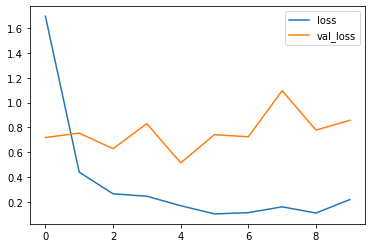

In [15]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

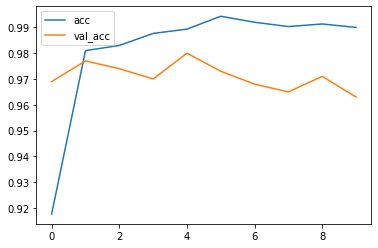

In [16]:
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()